In [36]:
import librosa
import librosa.display, os
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
want_num = 88
dance_path = f'./sounds/dance/dance{want_num}.wav'
bal_path = f'./sounds/ballade/balad{want_num}.wav'
ipd.Audio(dance_path)

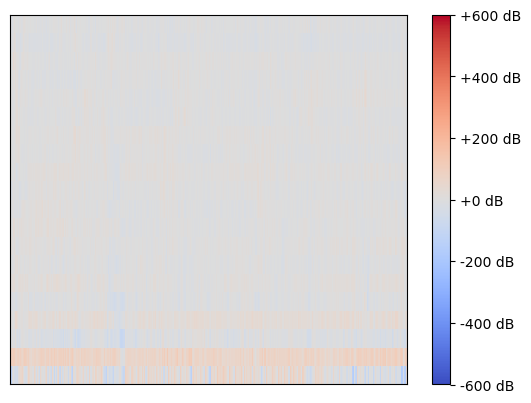

In [37]:
# 데이터 저장 
#폴더 경로 지정하기 -> dance
path='./sounds/ballade'
path='./sounds/dance'

#해당 폴더 안에 있는 파일 리스트 불러오기
file_names = os.listdir(path) # 'dance1.wav'...

# 일단 시험삼아 5개만 해보자 
for file_name in file_names[:]:
    # print("start ===================")
    save_path = './data/presentaion/img/'+file_name.split(".")[0]
    if file_name.split(".")[0][-2].isdecimal():
        numbers = int(file_name.split(".")[0][-2:])
    elif file_name.split(".")[0][-1].isdecimal():
        numbers = int(file_name.split(".")[0][-1:])
    # print(numbers)
    # print(path+file_name)
    # sr = 1초당 몇개의 데이터를 샘플링을 할지 
    if numbers == want_num:
        y, sr = librosa.load(path+"/"+file_name, sr=16000)
        
        ###### STFT (Short-Time Fourier Transform)
        n_fft = 2048 # window의 크기
        hop_length = 512  # window간 겹치는 부분 일반적으로 n_fft / 4
    
        ######
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, n_fft=n_fft, hop_length=hop_length) # sr 주의!!! 
    
        # print("MFCC Shape: ", mfcc.shape)
        # print("MFCC: \n", mfcc)
    
        ##### plt.figure(figsize = (10,5))
        min_value, max_value = -600, 600
        librosa.display.specshow(mfcc, sr=16000, hop_length=hop_length, vmin=min_value, vmax=max_value) # vmin=min_value, vmax=max_value
        plt.savefig(save_path, pad_inches = 0, bbox_inches = 'tight')
        # plt.xlabel("Time")
        # plt.ylabel("Frequency")
        plt.colorbar(format='%+2.0f dB')
        plt.show()


In [38]:
# 모듈 로딩
import pandas as pd
import numpy as np

from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt

# 사전 학습된 모델 로딩
import torchvision.models as models # 다양한모델패키지
model_vgg = models.vgg16(pretrained=True)

# 사전 훈련된 모델의 파라미터 학습 유무 설정 함수
def set_parameter_requires_grad(model, feature_extract = True):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False # 학습하는 것을 방지

set_parameter_requires_grad(model_vgg) # 함수 호출

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # VGG16의 특성 추출기 부분만 가져오기
        self.features = model_vgg.features
        # VGG16의 특성 추출기의 출력 크기 계산
        self.num_features = 512 * 1 * 1  # VGG16은 입력 이미지를 224x224 크기로 처리하므로, 여기서는 1x1로 출력됩니다.
        # 이진 분류를 위한 새로운 fully connected layer 정의
        self.fc = nn.Sequential(
            nn.Linear(self.num_features, 4096),  # 특성 추출기의 출력 크기를 입력으로 받음
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1),  # 이진 분류를 위한 출력 뉴런 수
            nn.Sigmoid()  # 이진 분류를 위한 시그모이드 활성화 함수
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x

# 모델 클래스 생성
model = CNN()
model.load_state_dict(torch.load('model_VGG16.pth'))
model.eval()  # 모델 추론으로 제발 좀

# 이미지 가져오기
from torchvision.datasets import ImageFolder

# 전처리
my_img_root = "./data/presentaion"

# C:\Users\kdp\PycharmProjects\EXAM_NLP\project_sound\data\for_pred
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

preprocessing = transforms.Compose([
    transforms.Resize((50, 50), interpolation=transforms.InterpolationMode.BILINEAR), # 1. resize
    # transforms.CenterCrop(224), # 2. 중앙크롭
    transforms.ToTensor(),  # 3. 값의 크기를 0~1로
    transforms.Normalize(mean=mean, std=std) # 4. normalized
])

pred_DS = ImageFolder(root=my_img_root, transform=preprocessing)
print(pred_DS.samples)
original_loader = DataLoader(pred_DS)


# GPU 연결 -> 물론 없음
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')


# print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

# 예측
def predict(model, val_loader):

    model.eval()
    correct = 0
    cnt = 0
    with torch.no_grad():
        for image, label in val_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            label = label.float()
            output = model(image)
            # print(output.max(1, keepdim = True))
            # print(output.round())
            prediction = output.round()  # 이진 분류에서는 반올림하여 0 또는 1로 변환
            if prediction.item() == 0:
                pred = "구슬픈 우리네의 발라드"
            else:
                pred = "가락이 구성진 뽕작"
            print("예측 ->", pred)
            real = pred_DS.samples[cnt][0].split("\\")[-1][:-4]
            print("정답 ->", real)
            print()

            correct += prediction.eq(label.view_as(prediction)).sum().item()
            cnt += 1
    # test_accuracy = 100. * correct / len(val_loader.dataset)
   

predict(model, original_loader)

# print(pred_DS.imgs)

[('./data/presentaion\\img\\dance88.png', 0)]
예측 -> 가락이 구성진 뽕작
정답 -> dance88
